###Introduction:


In recent situation Air pollution is a serious problem of public life hazards, so it's impprtant to monitor the air quality every now and then and take proper precautionary measures. Air pollution from particulate matter (PM) is on of the leading causes of global deaths.

Continuous ambient air quality monitoring stations (CAAMQS) can be deployed to monitor the various real-time values of PM2.5 values to have an eye on air quality continuously.But these stations can't be made as dense deployment as they are cost-ineffective. 

In recent years low cost wireless PM2.5 sensors (LCDS) have been emrging out, filling out the gap with high spatial and temporal resolution but their reliability is not impressive like CAAQMS. So, method of calibration is needed for LCDS against CAAMQS.


Importing necessary libraries

In [1]:
import math
import numpy as np
import pandas as pd

In [2]:
pip install openpyxl==3.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 172 kB 6.9 MB/s 
  Created wheel for openpyxl: filename=openpyxl-3.0.0-py2.py3-none-any.whl size=241207 sha256=2511ded117a6131068bc33bcd14cf7485868e044a5a0a65a7b51931ba0b821dd
  Stored in directory: /root/.cache/pip/wheels/c7/64/ff/ce98f6e1d2701ae8e216c875da62feed2839ac8a3cae0ab8af
Successfully built openpyxl
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.10
    Uninstalling openpyxl-3.0.10:
      Successfully uninstalled openpyxl-3.0.10


###Data Reading of CAAMQS and various LCDS:


Reading the data of CAAMQS of preferred location.

In [3]:
import openpyxl

In [4]:
#CAAQMS data ###reference monitor
def reference_data(name):
    '''function reference_data: Read the CAAQMS data file in .xlsx format
    Input:-
    name: location name
    Output:-
    df1: Dataframe having CAAQMS data'''
    name = name
    df = pd.read_excel(r'/content/drive/MyDrive/air_sensor_calibration/CAAQMS_MPCB-20220124T041833Z-001/CAAQMS_MPCB/MPCB_'+name+'.xlsx',engine='openpyxl')
    print(df.iloc[5:6,1:2])
    df = df.drop(range(0,15))
    df.columns = df.iloc[[0]].values.flatten().tolist()
    df = df.drop(15).reset_index().drop('index',axis=1)
    df.rename(columns={"PM2.5": "PM25_Ref","PM10": "PM10_Ref", 'RH':'RH_Ref','AT':'AT_Ref'},inplace=True)#,'WS':'WS_Ref'
    df = df[["From Date", "PM25_Ref",'PM10_Ref','RH_Ref','AT_Ref']]
    df['Date']=pd.to_datetime(df["From Date"], dayfirst = True)
    df= df.set_index('Date').drop(["From Date"],axis=1)
    print(f'Shape of the Reference data matrix for {name} is {df.shape}')
    return df

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
reference_data('Mahape').head(20)

                   Unnamed: 1
5  Mahape, Navi Mumbai - MPCB
Shape of the Reference data matrix for Mahape is (5320, 4)


,PM25_Ref,PM10_Ref,RH_Ref,AT_Ref
Date,,,,
2020-11-01 00:00:00,95.98,170.47,99.9,27.84
2020-11-01 01:00:00,79.39,116.8,99.9,27.58
2020-11-01 02:00:00,83.28,133.57,99.9,26.73
2020-11-01 03:00:00,92.14,138,99.9,26.62
2020-11-01 04:00:00,110.22,181.35,99.9,26.05
2020-11-01 05:00:00,100.22,144.8,99.9,26
2020-11-01 06:00:00,91.89,146.35,99.9,25.78
2020-11-01 07:00:00,89,131.9,99.9,25.99
2020-11-01 08:00:00,85.91,154.5,99.9,29.81


Reading LCDS data.

LCDS are of 4 types as listed below:

1) Respirer\
2) Airveda\
3) Oizom\
4) PAQS

In [7]:
#####respirer sensor data
def respirer_data(name):
    '''function respirer_data: Read the respirer data file in .csv format
    Input:-
    name: location name
    Output:-
    df1: Dataframe having Respirer data'''
    name1 = name.lower()
    df_S = pd.read_csv(r'/content/drive/MyDrive/air_sensor_calibration/RESPIRER-20220124T041844Z-001/RESPIRER/hourly_data/hour_data_03-06-2021_RESP_' + name1 + '.csv')
    df_S['Date'] = pd.to_datetime(df_S['dt_time'], dayfirst=True)
    df_S = df_S.set_index('Date')
    df_S.rename(columns={"pm2.5cnc": "pm25", "pm10cnc": "pm10"}, inplace=True)
    df_S= df_S.loc[:,['pm25','pm10','temp','rh']]
    print(f'Shape of the Respirer data matrix for {name} is {df_S.shape}')
    return df_S

In [14]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

Function for calculating Mean Absolute Percentage Error.

In [15]:
def mape(y_true,y_pred):
    '''function mape: computes the mean absolute percentage error
    Inputs:-
    y_true: CAAQMS values.
    y_pred: Calibrated /uncalibrated values of the LCS
    Output:-
    MAPE in %'''
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

In [16]:
def mae(y_true,y_pred):
    '''function mape: computes the mean absolute percentage error
    Inputs:-
    y_true: CAAQMS values.
    y_pred: Calibrated /uncalibrated values of the LCS
    Output:-
    MAPE in %'''
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)))

In [18]:
def ae(y_true,y_pred):
    '''function mape: computes the mean absolute percentage error
    Inputs:-
    y_true: CAAQMS values.
    y_pred: Calibrated /uncalibrated values of the LCS
    Output:-
    MAPE in %'''
    y_true,y_pred = np.squeeze(y_true),np.squeeze(y_pred)
    return (np.abs((y_true - y_pred)))

Function for calculating Symmetiric Mean Absolute Percentage Error.

In [19]:
def smape(y_true, y_pred):
    '''function smape: computes the symmetric mean absolute percentage error
    Inputs:-
    y_true: CAAQMS values.
    y_pred: Calibrated /uncalibrated values of the LCS
    Output:-
    SMAPE in %'''
    return 100/len(y_true) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

Merging all the 4 types of LCdS data with CAAQMS data for building input data-pair pipelines with base features.

Merging will be carried out by selecting the rows from both LCDS and CAAQMS dataframe based on common indexes they have and lastly join them columnwise. As anyone can see for 4 cases of merging , e.g: Respirer sensor dataset is having 4760 rows and CAAQMS dataset is having 5320 rows, so resultant shape of merged dataset is:
(4760,8)

generalized formula for merging is as below:

(min(LCDS_data.shape[0],CAAQMS_data.shape[0]),LCDS_data.shape[1]+CAAQMS_data.shape[1])

Base features for LCDS are \
1)PM2.5\
2)PM10\
3)RH\
4)AT

Base features for CAAQMS are \
1)PM2.5_ref\
2)PM10_ref\
3)RH_ref\
4)AT_ref

After merging the dataset will have all the above mentioned 8 features.

Merging **''Respirer''** sensor data with CAAQMS data for a particular location

In [20]:
#########data_merging_respirer######
def data_merge_resp(name):
    '''function data_merge_resp: combine the CAAQMS data and Respirer data into one dataframe
    Input:-
    name: location name
    Output:-
    df1: Dataframe having CAAQMS and LCS data'''
    LCS = 'Respirer'
    df_ref =  reference_data(name)
    df_lcs= respirer_data(name)
    df1 = df_ref.merge(df_lcs, left_index=True, right_index=True)
    #df1 = df1.loc[:'04-12-2020 11:00 PM']
    print(f'shape of the merge dataset at {name} for {LCS} is {df1.shape}')
    return df1

In [21]:

data_merge_resp('Mahape')

                   Unnamed: 1
5  Mahape, Navi Mumbai - MPCB
Shape of the Reference data matrix for Mahape is (5320, 4)
Shape of the Respirer data matrix for Mahape is (4762, 4)
shape of the merge dataset at Mahape for Respirer is (4762, 8)


,PM25_Ref,PM10_Ref,RH_Ref,AT_Ref,pm25,pm10,temp,rh
Date,,,,,,,,
2020-11-01 00:00:00,95.98,170.47,99.9,27.84,83.380952,93.079365,26.000000,53.365079
2020-11-01 01:00:00,79.39,116.8,99.9,27.58,87.539683,97.301587,25.619048,54.857143
2020-11-01 02:00:00,83.28,133.57,99.9,26.73,88.983871,98.951613,24.935484,59.403226
2020-11-01 03:00:00,92.14,138,99.9,26.62,137.539683,151.857143,24.269841,62.349206
2020-11-01 04:00:00,110.22,181.35,99.9,26.05,122.419355,136.677419,24.000000,63.983871
...,...,...,...,...,...,...,...,...
2021-06-03 15:00:00,24.67,56.8,99.9,38.87,12.451613,13.274194,38.967742,40.903226
2021-06-03 16:00:00,17.87,44.42,99.9,38.05,4.349206,5.174603,36.936508,44.809524
2021-06-03 17:00:00,13.55,26.67,99.9,37.2,5.857143,6.365079,35.809524,49.111111


###Making of derived features.


In our work we found derived features from base features have an important relationship with PM2.5 values which plays an crucial role in explaining the observed values of PM2.5 values.

We have prepared 23 derived features from base features namely:

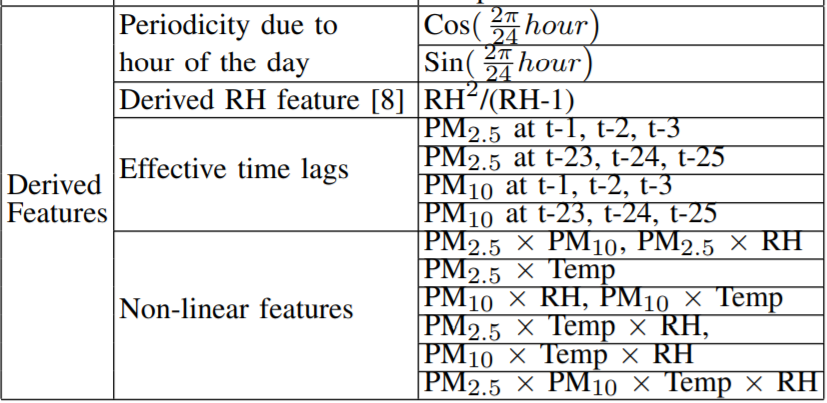

To show the relationship of 23 derived features and 4 base features with PM2.5 values we have calculated and plotted pearson correlation coefficients of 27 features with PM2.5 values according to below formula.

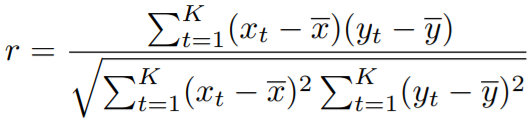

Where x_t and y_t denote the value of t
th feature and
CAAQMS PM2.5, respectively. The x_bar and y_bar represent the
mean value of the features and CAAQMS PM2.5 respectively

We have found all the 23 derived features with having 4 base features have positive values of pearson plotted as below:
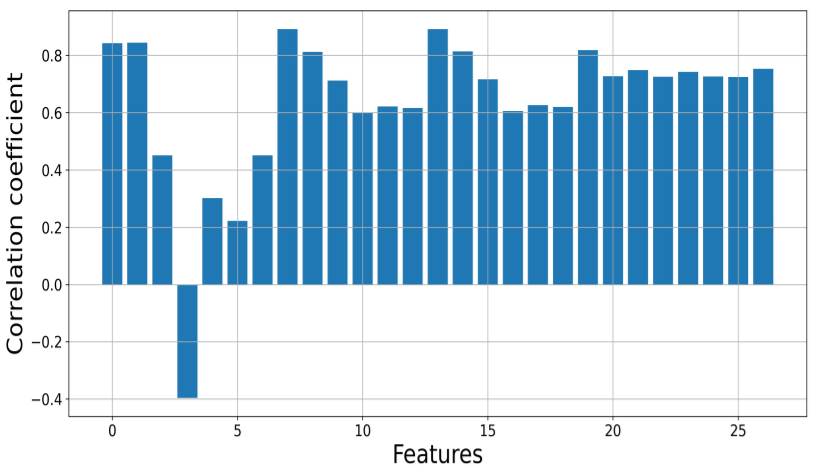

where only one feature 'air temparature' out of those 27 features is having negative pearson correlation co-efficient values which indicates that temparature has an inverse relationship with Pm2.5 values. 

Lastly it's also crystal clear that all those derived features have positive correlation co-efficient playing an important riole in calibrating PM2.5 values.


Function for calculating the derived features.

In [26]:
################features preparation#############
####################################
def derived_feat(df):
    '''function derived_feature: prepare the derived features and add them to the dataframe of the base features
     Input:-
    df: Dataframe having base features and CAAQMS values
    Output:-
    df: Dataframe having base, derived features, and CAAQMS values'''
    df.Date = pd.to_datetime(df.Date,dayfirst=True)
    df['hour'] = df.Date.dt.strftime('%H').astype(int)+1
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
    df['rh_11'] = (df['rh']*df['rh'])/(df['rh'] - 1)
    # for pm2.5 lags values
    x_pm25 = [25,24,23,3,2,1]
    for i in x_pm25:
        df['(PM25)t-'+str(i)] = df['pm25'].shift(i)
    # for pm10 lags values
    x_pm10 = [25,24,23,3,2,1]
    for i in x_pm10:
        df['(PM10)t-'+str(i)] = df['pm10'].shift(i)
    # multiplication based features
    df['p1p2'] = df['pm25']*df['pm10']
    df['p1r'] = df['pm25']*df['rh']
    df['p1t'] = df['pm25']*df['temp']
    df['p2r'] = df['pm10']*df['rh']
    df['p2t'] = df['pm10']*df['temp']
    df['p1rt'] = df['pm25']*df['rh']*df['temp']
    df['p2rt'] = df['pm10']*df['rh']*df['temp']
    df['p1p2rt'] = df['pm25']*df['pm10']*df['rh']*df['temp']
    return df

In [27]:
name_list=['Airport','Mahape','Vileparle','Nerul','Sion','Kalyan','Worli',
           'Bandra','Kandivali','Borivali','Vasai','Powai','Mulund','Kurla','Colaba'] # loactions where 4 types of LCDS sensors are deployed
seasons = ['season_1','season_2']
startup = 'Respirer' # LCDS sensors

In [28]:
name1 = name_list[1]##########select collocated site as per the name given in the name_list
#########chosing season ### 0=season_1 and 1=season_2
season = seasons[0]

In [29]:
df = data_merge_resp(startup)  
##################select season
if season == 'season_1':########season_1
    df = df.loc['2020-11-01 00:00:00':'2021-01-31 23:00:00']
else:###########season_2
    df = df.loc['2021-02-01 00:00:00':'2021-05-31 23:00:00']
########droping the Temp, RH, and PM10 of the CAAQMS from the dataset####

                   Unnamed: 1
5  Mahape, Navi Mumbai - MPCB
Shape of the Reference data matrix for Mahape is (5320, 4)
Shape of the Respirer data matrix for Mahape is (4762, 4)
shape of the merge dataset at Mahape for Respirer is (4762, 8)


After merging the CAAQMS and LCDS dataset for a preferred location be like:

In [30]:
df.head(20)

,PM25_Ref,PM10_Ref,RH_Ref,AT_Ref,pm25,pm10,temp,rh
Date,,,,,,,,
2020-11-01 00:00:00,95.98,170.47,99.9,27.84,83.380952,93.079365,26.000000,53.365079
2020-11-01 01:00:00,79.39,116.8,99.9,27.58,87.539683,97.301587,25.619048,54.857143
2020-11-01 02:00:00,83.28,133.57,99.9,26.73,88.983871,98.951613,24.935484,59.403226
2020-11-01 03:00:00,92.14,138,99.9,26.62,137.539683,151.857143,24.269841,62.349206
2020-11-01 04:00:00,110.22,181.35,99.9,26.05,122.419355,136.677419,24.000000,63.983871
2020-11-01 05:00:00,100.22,144.8,99.9,26,103.253968,114.730159,24.000000,62.920635
2020-11-01 06:00:00,91.89,146.35,99.9,25.78,93.650794,104.460317,23.571429,64.730159
2020-11-01 07:00:00,89,131.9,99.9,25.99,112.048387,125.080645,23.838710,66.693548
2020-11-01 08:00:00,85.91,154.5,99.9,29.81,89.333333,98.206349,26.761905,56.396825


Dropping the 3 features out of 8 features in the merged dataset.

In [31]:
df = df.drop(['AT_Ref', 'PM10_Ref', 'RH_Ref'], axis=1)
df = df.reset_index()


After dropping 3 features out of 8 features the resultant dataframe be like:

In [32]:

df.head(10)

,Date,PM25_Ref,pm25,pm10,temp,rh
0,2020-11-01 00:00:00,95.98,83.380952,93.079365,26.000000,53.365079
1,2020-11-01 01:00:00,79.39,87.539683,97.301587,25.619048,54.857143
2,2020-11-01 02:00:00,83.28,88.983871,98.951613,24.935484,59.403226
3,2020-11-01 03:00:00,92.14,137.539683,151.857143,24.269841,62.349206
4,2020-11-01 04:00:00,110.22,122.419355,136.677419,24.000000,63.983871
5,2020-11-01 05:00:00,100.22,103.253968,114.730159,24.000000,62.920635
6,2020-11-01 06:00:00,91.89,93.650794,104.460317,23.571429,64.730159
7,2020-11-01 07:00:00,89,112.048387,125.080645,23.838710,66.693548
8,2020-11-01 08:00:00,85.91,89.333333,98.206349,26.761905,56.396825
9,2020-11-01 09:00:00,70.22,52.888889,64.095238,31.047619,40.761905


In [33]:
####################prepare features################
df = derived_feat(df)
print('Top 1 Rows:\n',df.head(1))

Top 1 Rows:
         Date PM25_Ref       pm25       pm10  temp         rh  hour  hour_sin  \
0 2020-11-01    95.98  83.380952  93.079365  26.0  53.365079     1  0.258819   

   hour_cos      rh_11  ...  (PM10)t-2  (PM10)t-1         p1p2          p1r  \
0  0.965926  54.384176  ...        NaN        NaN  7761.046107  4449.631141   

           p1t          p2r          p2t           p1rt           p2rt  \
0  2167.904762  4967.187705  2420.063492  115690.409675  129146.880322   

         p1p2rt  
0  1.076839e+07  

[1 rows x 30 columns]


In [34]:
df.columns

Index(['Date', 'PM25_Ref', 'pm25', 'pm10', 'temp', 'rh', 'hour', 'hour_sin',
       'hour_cos', 'rh_11', '(PM25)t-25', '(PM25)t-24', '(PM25)t-23',
       '(PM25)t-3', '(PM25)t-2', '(PM25)t-1', '(PM10)t-25', '(PM10)t-24',
       '(PM10)t-23', '(PM10)t-3', '(PM10)t-2', '(PM10)t-1', 'p1p2', 'p1r',
       'p1t', 'p2r', 'p2t', 'p1rt', 'p2rt', 'p1p2rt'],
      dtype='object')

Function for calculating outliers for air temparature and relative humidity features and removing them finally.

In [35]:
##############outlier_removal##########
''' '''
def temp_rh_outliers(df):
    """function temp_rh_outliers: use to replace the outliers by np.nan, if any.
    Replace value of temp by nan if temp>50
    and Replace value of rh by nan if rh>100
    Input:-
    df: Dataframe having temperature and humidity as feature
    Note: temperature is named as: temp. humidity is named as: rh
    Output:-
    df: Dataframe-all outliers are replaced by np.nan
    """
    temp_max = 50
    rh_max = 100
    for i in range(len(df)):
        if df['temp'][i] > temp_max:
            df['temp'][i] = np.nan
    for i in range(len(df)):
        if df['rh'][i] > rh_max:
            df['rh'][i] = np.nan
    return df

In [36]:
df = temp_rh_outliers(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
df

,Date,PM25_Ref,pm25,pm10,temp,rh,hour,hour_sin,hour_cos,rh_11,...,(PM10)t-2,(PM10)t-1,p1p2,p1r,p1t,p2r,p2t,p1rt,p2rt,p1p2rt
0,2020-11-01 00:00:00,95.98,83.380952,93.079365,26.000000,53.365079,1,2.588190e-01,0.965926,54.384176,...,NaN,NaN,7761.046107,4449.631141,2167.904762,4967.187705,2420.063492,115690.409675,129146.880322,1.076839e+07
1,2020-11-01 01:00:00,79.39,87.539683,97.301587,25.619048,54.857143,2,5.000000e-01,0.866025,55.875710,...,NaN,93.079365,8517.750063,4802.176871,2242.683296,5337.687075,2492.773998,123027.197927,136746.459346,1.197074e+07
2,2020-11-01 02:00:00,83.28,88.983871,98.951613,24.935484,59.403226,3,7.071068e-01,0.707107,60.420348,...,93.079365,97.301587,8805.097555,5285.928980,2218.855879,5878.045005,2467.406348,131807.196830,146571.896420,1.304253e+07
3,2020-11-01 03:00:00,92.14,137.539683,151.857143,24.269841,62.349206,4,8.660254e-01,0.500000,63.365506,...,97.301587,98.951613,20886.383220,8575.490048,3338.066264,9468.172336,3685.548753,208125.782273,229791.039701,3.160539e+07
4,2020-11-01 04:00:00,110.22,122.419355,136.677419,24.000000,63.983871,5,9.659258e-01,0.258819,64.999748,...,98.951613,151.857143,16731.961498,7832.864204,2938.064516,8745.150364,3280.258065,187988.740895,209883.608741,2.569382e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2203,2021-01-31 19:00:00,72.7,70.619048,79.698413,27.587302,32.777778,20,-8.660254e-01,0.500000,33.809246,...,66.079365,71.322581,5628.226002,2314.735450,1948.188964,2612.336861,2198.664147,63857.304947,72067.324823,5.089326e+06
2204,2021-01-31 20:00:00,80.32,75.444444,85.222222,26.507937,34.301587,21,-7.071068e-01,0.707107,35.331616,...,71.322581,79.698413,6429.543210,2587.864198,1999.876543,2923.257496,2259.065256,68598.939839,77489.524089,5.846154e+06
2205,2021-01-31 21:00:00,90.11,104.790323,118.725806,25.419355,37.951613,22,-5.000000e-01,0.866025,38.978675,...,79.698413,85.222222,12441.315557,3976.961759,2663.702393,4505.835848,3017.933403,101091.802121,114535.440267,1.200221e+07
2206,2021-01-31 22:00:00,113.65,98.857143,110.761905,25.000000,37.301587,23,-2.588190e-01,0.965926,38.329134,...,85.222222,118.725806,10949.605442,3687.528345,2471.428571,4131.594860,2769.047619,92188.208617,103289.871504,1.021094e+07


In [38]:
df = df.replace([np.inf, -np.inf],np.nan)
df = df.replace(0,np.nan)
df = df.mask(df.eq('None')).dropna()

In [39]:
np.max(df['PM25_Ref'].values)

235.67

In [40]:
df['PM25_Ref'].values.shape

(1917,)

In [41]:
import tensorflow_probability as tfp

In [42]:
tfd = tfp.distributions

### Standardization of feature values.

Standardize the feature values following the below formula:

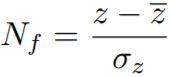

Where N_f and z denote the normalized input features and
actual input features, the z_bar and σ_z represent the mean and
standard deviation of the actual input features.

In [43]:
innu1 = df.drop(['Date','PM25_Ref'],axis=1)

In [44]:

innu1.columns

Index(['pm25', 'pm10', 'temp', 'rh', 'hour', 'hour_sin', 'hour_cos', 'rh_11',
       '(PM25)t-25', '(PM25)t-24', '(PM25)t-23', '(PM25)t-3', '(PM25)t-2',
       '(PM25)t-1', '(PM10)t-25', '(PM10)t-24', '(PM10)t-23', '(PM10)t-3',
       '(PM10)t-2', '(PM10)t-1', 'p1p2', 'p1r', 'p1t', 'p2r', 'p2t', 'p1rt',
       'p2rt', 'p1p2rt'],
      dtype='object')

In [45]:
innu_f1 = innu1.iloc[:,:].values

In [46]:

innu_f1.shape

(1917, 28)

In [47]:
outu1 = df[['PM25_Ref']]

In [48]:
outu_f1 = outu1.iloc[:,:].values

In [49]:
from matplotlib import pyplot as plt

In [51]:
def diracdelta_generator(gnd_out,bin_borders):
  from collections import deque
  from scipy import signal
  bin_probs = deque()
  cls_indx = np.searchsorted(bin_borders,gnd_out)-1
  for i in range (gnd_out.shape[0]):
    bin_probs.append(signal.unit_impulse((bin_borders.shape[0]-1),cls_indx[i]))
  return np.asarray(bin_probs)

### Splitting the data into training,validation,test data.

In [52]:
##############data split#######
def data_split(df, a,b):
    '''function data_split: use to split tha dataset into training, validation, and test data'''
    train = df[:a, :].astype(np.float32)
    val = df[a:a + b, :].astype(np.float32)
    test = df[a + b:, :].astype(np.float32)
    return train, val, test

In [53]:
def z_nor_27(df,a,b):
    '''function z_nor_27: use to standardize the data before feeding to the model. 27_refers that it uses
    27 features (base+ derived features)
    Input:-
    df: Dataframe that must have 27 columns including following columns: ['Date','PM25_Ref','hour','hour_sin','hour_cos']
    Output:-
    df: Dataframe having standardized values
    '''
    innu = df.drop(['hour','hour_sin','hour_cos'],axis=1)
    outu = df[['hour_sin','hour_cos']]
    innu_train,innu_val,innu_test = data_split(innu.values,a,b)
    outu_train,outu_val,outu_test = data_split(outu.values,a,b)
    sc = StandardScaler()
    train_innu_scaled = sc.fit_transform(innu_train)
    val_innu_scaled = sc.transform(innu_val)
    test_innu_scaled = sc.transform(innu_test)
    train_df1,val_df1,test_df1 = np.concatenate((outu_train,train_innu_scaled),axis=1),np.concatenate((outu_val,val_innu_scaled),axis=1), np.concatenate((outu_test,test_innu_scaled),axis=1)
    return train_df1,val_df1,test_df1

In [ ]:
b = 336##############No. of hours in Test data
a = df.shape[0] - b*2

In [55]:
X_train,X_val,X_test = z_nor_27(innu1,a,b)
y_train,y_val,y_test = data_split(outu_f1,a,b)

###Deep neural network(DNN) model formation and training

In [56]:
from tensorflow.python.framework import tensor_conversion_registry
############
'''importing useful libraries'''
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import sys
import math
from tensorflow.keras.losses import Loss
from keras.layers import Concatenate



*  The base model which is a fully connected DNN having 7 hidden layers excluding
input and output. This model is being used in source location for end-to-end training and later on it was used for transfering knowledge gained from features in target location.
*  In target location the output layer of base model is popped out and another layer is being added on top of the existing layers of base model.
*  Then this modified model at target location is trained by freezing the weights of the base model and running the base model into inference mode rather than in training mode.In this phase of training the knowledge of base model being trained at source loaction is distilled to the newly added layer at top of the base model.
*  Lastly, the whole model (base model + newly added layer on top of it) is fine-tuned using a much lower learning rate to prevent the overfitting.



Contructing the base model.

In [57]:
class functional_base_model(keras.models.Model):
  def __init__(self,num_bins):
    super(functional_base_model,self).__init__()
    self.layer_1 = Dense(512,kernel_initializer='normal',activation='relu')
    self.layer_2 = Dense(256,kernel_initializer='normal',activation='relu')
    self.layer_3 = Dense(256,kernel_initializer='normal',activation='relu')
    self.layer_4 = Dense(256,kernel_initializer='normal',activation='relu')
    self.layer_5 = Dense(256,kernel_initializer='normal',activation='relu')
    self.layer_6 = Dense(200,kernel_initializer='normal',activation='relu')
    self.out_layer = Dense(num_bins,activation='softmax')
  def call(self,inputs):
    x = self.layer_1(inputs)
    x = self.layer_2(x)
    x = self.layer_3(x)
    x = self.layer_4(x)
    x = self.layer_5(x)
    lr6_out = self.layer_6(x)
    his_est_out = self.out_layer(lr6_out)
    return his_est_out,lr6_out

Making the predictions on training,validation,test set at source locations by the base model.

In [58]:
def predicted_out(X,bin_borders,model):
  ndn_pred = model(X)
  bin_values = np.repeat(np.expand_dims([np.mean([bin_borders[i],bin_borders[i+1]]) for i in range (bin_borders.shape[0]-1)],axis=0),ndn_pred.shape[0],axis=0) 
  expected_out = tf.math.reduce_sum(tf.math.multiply(ndn_pred,bin_values),axis=1)
  return expected_out

In [59]:
def tpredicted_out(X,bin_borders,model):
  ndn_pred = model(X)
  bin_values = np.repeat(np.expand_dims([np.mean([bin_borders[i],bin_borders[i+1]]) for i in range (bin_borders.shape[0]-1)],axis=0),ndn_pred[0].shape[0],axis=0) 
  expected_out = tf.math.reduce_sum(tf.math.multiply(ndn_pred[0],bin_values),axis=1)
  return expected_out

In [60]:
def actual_out(y,bin_borders):
  bin_values = np.repeat(np.expand_dims([np.mean([bin_borders[i],bin_borders[i+1]]) for i in range (bin_borders.shape[0]-1)],axis=0),y.shape[0],axis=0) 
  actual_out = tf.math.reduce_sum(tf.math.multiply(y,bin_values),axis=1)
  return actual_out

###Plotting the predicted values on training,validation,test dataset against the ground truth values of all those 3 types of datasets at source location.

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [61]:
def importance_weight_cal(unlab_tfeat,lab_stfeat,slab_train_logits,tlab_train_logits):
  rep_unlab_out = tf.repeat(tf.expand_dims(unlab_tfeat[1],axis=1),tf.shape(slab_train_logits[0])[0]+tf.shape(tlab_train_logits[0])[0],axis=1)
  rep_lab_out = tf.repeat(tf.expand_dims(lab_stfeat[1],axis=0),unlab_tfeat[1].shape[0],axis=0)
  oneNN_dist = tf.math.reduce_min(tf.sqrt(tf.reduce_sum((tf.math.subtract(rep_unlab_out,rep_lab_out))**2,axis=2)),axis=1)
  importance_wt = tf.math.exp(tf.constant(-1,dtype=tf.float32)*oneNN_dist)
  return importance_wt

In [62]:
def grads_cal(sX_train,sy_train,lab_tar_X_train,ty_train,lab_X_train,unlab_tar_X_train,base_mod,objective_weighting_values,CE_loss_fn,cond_ent_loss_fn,i):
  with tf.GradientTape() as ltape:
    slab_train_logits = base_mod(sX_train)
    slab_train_loss = CE_loss_fn(sy_train,slab_train_logits[0])
    tlab_train_logits = base_mod(lab_tar_X_train)
    tlab_train_loss = CE_loss_fn(ty_train,tlab_train_logits[0])
    lab_stfeat = base_mod(lab_X_train)
    unlab_tfeat = base_mod(unlab_tar_X_train)
    ce_grads = ltape.gradient((slab_train_loss+tlab_train_loss),base_mod.trainable_variables)
  importance_wt = importance_weight_cal(unlab_tfeat,lab_stfeat,slab_train_logits,tlab_train_logits)
  with tf.GradientTape() as utape:
    unlab_train_logits = base_mod(unlab_tar_X_train)
    unlab_train_loss = tf.constant(objective_weighting_values[i],dtype=tf.float32)*tf.reduce_mean(cond_ent_loss_fn(unlab_train_logits[0],unlab_train_logits[0],sample_weight=importance_wt))
    cond_ent_grads = utape.gradient(unlab_train_loss,base_mod.trainable_variables)
  return ce_grads,cond_ent_grads

In [ ]:
#@tf.function
def semsupww_grads_cal(sX_train,sy_train,lab_tar_X_train,ty_train,unlab_tar_X_train,base_mod,objective_weighting_values,CE_loss_fn,cond_ent_loss_fn,i):
  with tf.GradientTape(persistent=True) as tape:
    slab_train_logits = base_mod(sX_train)
    slab_train_loss = CE_loss_fn(sy_train,slab_train_logits[0])
    tlab_train_logits = base_mod(lab_tar_X_train)
    tlab_train_loss = CE_loss_fn(ty_train,tlab_train_logits[0])
    unlab_train_logits = base_mod(unlab_tar_X_train)
    unlab_train_loss = tf.constant(objective_weighting_values[i],dtype=tf.float32)*tf.reduce_mean(cond_ent_loss_fn(unlab_train_logits[0],unlab_train_logits[0]))
    ce_grads = tape.gradient((slab_train_loss+tlab_train_loss),base_mod.trainable_variables)
    cond_ent_grads = tape.gradient(unlab_train_loss,base_mod.trainable_variables)
  return ce_grads,cond_ent_grads

In [ ]:
def semsupTG_performance_eval(sinnu_f1,soutu_f1,tinnu_f1,toutu_f1,num_bins,sa,sb,ta,tb,tc,td):
  soutu = np.squeeze(soutu_f1)
  toutu = np.squeeze(toutu_f1)
  sgnd_out = soutu.astype(np.float32)
  tgnd_out = toutu.astype(np.float32)
  sX_train,sX_val,sX_test = z_nor_27(sinnu_f1,sa,sb)
  tar_sc = StandardScaler()
  tar_X_train = tinnu_f1[:tb,:].astype(np.float32)
  tar_X_val = tinnu_f1[tb:tc,:].astype(np.float32)
  tar_X_test = tinnu_f1[tc:td,:].astype(np.float32)
  nor_tar_X_train = tar_sc.fit_transform(tar_X_train)
  nor_tar_X_val = tar_sc.transform(tar_X_val)
  nor_tar_X_test = tar_sc.transform(tar_X_test)
  lab_tar_X_train = nor_tar_X_train[:ta,:].astype(np.float32)
  unlab_tar_X_train = nor_tar_X_train[ta:tb,:].astype(np.float32)
  lab_X_train = np.concatenate((sX_train,lab_tar_X_train),axis=0)
  dist_min,dist_max = 0,800
  target_r2_scores = []
  target_mae = []
  dom_adap_model_collector = []
  bin_borders_collector = []
  ty_test_collector = []
  objective_weighting_values = [0 if i<=15 else ((i-15)/(80-15))*0.1 if i>15 and i<=80 else 0.1 for i in range (200)]
  for num in num_bins:
    print('Starting of training with {} bins'.format(num))
    bin_borders = np.linspace(dist_min,dist_max,num=(num+1)).astype(np.float32)
    stddev_gnd_out = np.sqrt(dist_max-dist_min/num.astype(np.float32))
    source_tar_dist = tfd.TruncatedNormal(loc=[sgnd_out[i] for i in range (sgnd_out.shape[0])],scale=stddev_gnd_out.astype(np.float32),low=dist_min,high=dist_max)
    target_tar_dist = tfd.TruncatedNormal(loc=[tgnd_out[i] for i in range (tgnd_out.shape[0])],scale=stddev_gnd_out.astype(np.float32),low=dist_min,high=dist_max)
    sleft_bound_cdf = np.asarray([source_tar_dist.cdf(bin_borders[i]) for i in range (bin_borders.shape[0]-1)])
    sright_bound_cdf = np.asarray([source_tar_dist.cdf(bin_borders[i]) for i in range (1,bin_borders.shape[0])])
    tleft_bound_cdf = np.asarray([target_tar_dist.cdf(bin_borders[i]) for i in range (bin_borders.shape[0]-1)])
    tright_bound_cdf = np.asarray([target_tar_dist.cdf(bin_borders[i]) for i in range (1,bin_borders.shape[0])])
    sbin_probs = (sright_bound_cdf-sleft_bound_cdf).T
    tbin_probs = (tright_bound_cdf-tleft_bound_cdf).T
    sy_train,sy_val,sy_test = data_split(sbin_probs, sa,sb)
    ty_train = tbin_probs[:ta,:].astype(np.float32)
    ty_val = tbin_probs[tb:tc,:].astype(np.float32)
    ty_test = tbin_probs[tc:td,:].astype(np.float32)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    CE_loss_fn = tf.keras.losses.CategoricalCrossentropy()
    cond_ent_loss_fn = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    base_mod = functional_base_model(num)
    for i in range (200):
      print(f'starting of epoch {i}')
      ce_grads,cond_ent_grads = grads_cal(sX_train,sy_train,lab_tar_X_train,ty_train,lab_X_train,unlab_tar_X_train,base_mod,objective_weighting_values,CE_loss_fn,cond_ent_loss_fn,i)
      feat_ex_weights = [base_mod.trainable_variables[i] for i in range (12)]
      optimizer.apply_gradients(zip(([-(cond_ent_grads[-2])+(ce_grads[-2]),-(cond_ent_grads[-1])+(ce_grads[-1])]),[base_mod.trainable_variables[-2],base_mod.trainable_variables[-1]]))
      optimizer.apply_gradients(zip([cond_ent_grads[i]+ce_grads[i] for i in range (12)],feat_ex_weights))
      sval_logits = base_mod(sX_val)
      sval_loss = CE_loss_fn(sy_val,sval_logits[0])
      tval_logits = base_mod(nor_tar_X_val)
      tval_loss = CE_loss_fn(ty_val,tval_logits[0])
      print('validation loss at source location {} and target location {} in epoch {}'.format(sval_loss,tval_loss,i))
    dom_adap_model_collector.append(base_mod)
    tndn_pred_val = tpredicted_out(nor_tar_X_val,bin_borders,base_mod)
    tactual_y_val = actual_out(ty_val,bin_borders)
    tval_r2_score = r2_score(tactual_y_val,tndn_pred_val)
    target_r2_scores.append(tval_r2_score)
    ty_test_collector.append(ty_test)
    print('R2 score at target location on validation set is {} in epoch {}'.format(tval_r2_score,i))
    bin_borders_collector.append(bin_borders)
  target_r2_scores = np.asarray(target_r2_scores)
  max_r2_idx = np.where(target_r2_scores==np.max(target_r2_scores))
  best_base_mod = dom_adap_model_collector[max_r2_idx[0][0]]
  tndn_pred_test = tpredicted_out(nor_tar_X_test,bin_borders_collector[max_r2_idx[0][0]],best_base_mod)
  tactual_y_test = actual_out(ty_test_collector[max_r2_idx[0][0]],bin_borders_collector[max_r2_idx[0][0]])
  ttest_r2_score,ttest_mae = r2_score(tactual_y_test,tndn_pred_test),mae(tactual_y_test,tndn_pred_test)
  ttest_mape,ttest_smape = mape(tactual_y_test,tndn_pred_test),smape(tactual_y_test,tndn_pred_test)
  print('R2 score,MAE,MAPE,SMAPE at target location are {},{},{},{} in epoch {}'.format(ttest_r2_score,ttest_mae,ttest_mape,ttest_smape,i))
  return best_base_mod

In [ ]:
def semsupTG_performance_wweval(sinnu_f1,soutu_f1,tinnu_f1,toutu_f1,num_bins,sa,sb,ta,tb,tc,td):
  soutu = np.squeeze(soutu_f1)
  toutu = np.squeeze(toutu_f1)
  sgnd_out = soutu.astype(np.float32)
  tgnd_out = toutu.astype(np.float32)
  sX_train,sX_val,sX_test = z_nor_27(sinnu_f1,sa,sb)
  tar_sc = StandardScaler()
  tar_X_train = tinnu_f1[:tb,:].astype(np.float32)
  tar_X_val = tinnu_f1[tb:tc,:].astype(np.float32)
  tar_X_test = tinnu_f1[tc:td,:].astype(np.float32)
  nor_tar_X_train = tar_sc.fit_transform(tar_X_train)
  nor_tar_X_val = tar_sc.transform(tar_X_val)
  nor_tar_X_test = tar_sc.transform(tar_X_test)
  lab_tar_X_train = nor_tar_X_train[:ta,:].astype(np.float32)
  unlab_tar_X_train = nor_tar_X_train[ta:tb,:].astype(np.float32)
  lab_X_train = np.concatenate((sX_train,lab_tar_X_train),axis=0)
  dist_min,dist_max = 0,800
  target_r2_scores = []
  target_mae = []
  dom_adap_model_collector = []
  bin_borders_collector = []
  ty_test_collector = []
  objective_weighting_values = [0 if i<=15 else ((i-15)/(80-15))*0.1 if i>15 and i<=80 else 0.1 for i in range (200)]
  for num in num_bins:
    print('Starting of training with {} bins'.format(num))
    bin_borders = np.linspace(dist_min,dist_max,num=(num+1)).astype(np.float32)
    stddev_gnd_out = np.sqrt(dist_max-dist_min/num.astype(np.float32))
    source_tar_dist = tfd.TruncatedNormal(loc=[sgnd_out[i] for i in range (sgnd_out.shape[0])],scale=stddev_gnd_out.astype(np.float32),low=dist_min,high=dist_max)
    target_tar_dist = tfd.TruncatedNormal(loc=[tgnd_out[i] for i in range (tgnd_out.shape[0])],scale=stddev_gnd_out.astype(np.float32),low=dist_min,high=dist_max)
    sleft_bound_cdf = np.asarray([source_tar_dist.cdf(bin_borders[i]) for i in range (bin_borders.shape[0]-1)])
    sright_bound_cdf = np.asarray([source_tar_dist.cdf(bin_borders[i]) for i in range (1,bin_borders.shape[0])])
    tleft_bound_cdf = np.asarray([target_tar_dist.cdf(bin_borders[i]) for i in range (bin_borders.shape[0]-1)])
    tright_bound_cdf = np.asarray([target_tar_dist.cdf(bin_borders[i]) for i in range (1,bin_borders.shape[0])])
    sbin_probs = (sright_bound_cdf-sleft_bound_cdf).T
    tbin_probs = (tright_bound_cdf-tleft_bound_cdf).T
    sy_train,sy_val,sy_test = data_split(sbin_probs, sa,sb)
    ty_train = tbin_probs[:ta,:].astype(np.float32)
    ty_val = tbin_probs[tb:tc,:].astype(np.float32)
    ty_test = tbin_probs[tc:td,:].astype(np.float32)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    CE_loss_fn = tf.keras.losses.CategoricalCrossentropy()
    cond_ent_loss_fn = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    base_mod = functional_base_model(num)
    for i in range (200):
      print(f'starting of epoch {i}')
      ce_grads,cond_ent_grads = semsupww_grads_cal(sX_train,sy_train,lab_tar_X_train,ty_train,unlab_tar_X_train,base_mod,objective_weighting_values,CE_loss_fn,cond_ent_loss_fn,i)
      feat_ex_weights = [base_mod.trainable_variables[i] for i in range (12)]
      optimizer.apply_gradients(zip(([-(cond_ent_grads[-2])+(ce_grads[-2]),-(cond_ent_grads[-1])+(ce_grads[-1])]),[base_mod.trainable_variables[-2],base_mod.trainable_variables[-1]]))
      optimizer.apply_gradients(zip([cond_ent_grads[i]+ce_grads[i] for i in range (12)],feat_ex_weights))
      sval_logits = base_mod(sX_val)
      sval_loss = CE_loss_fn(sy_val,sval_logits[0])
      tval_logits = base_mod(nor_tar_X_val)
      tval_loss = CE_loss_fn(ty_val,tval_logits[0])
      print('validation loss at source location {} and target location {} in epoch {}'.format(sval_loss,tval_loss,i))
    dom_adap_model_collector.append(base_mod)
    tndn_pred_val = tpredicted_out(nor_tar_X_val,bin_borders,base_mod)
    tactual_y_val = actual_out(ty_val,bin_borders)
    tval_r2_score = r2_score(tactual_y_val,tndn_pred_val)
    target_r2_scores.append(tval_r2_score)
    ty_test_collector.append(ty_test)
    print('R2 score at target location on validation set is {} in epoch {}'.format(tval_r2_score,i))
    bin_borders_collector.append(bin_borders)
  target_r2_scores = np.asarray(target_r2_scores)
  max_r2_idx = np.where(target_r2_scores==np.max(target_r2_scores))
  best_base_mod = dom_adap_model_collector[max_r2_idx[0][0]]
  tndn_pred_test = tpredicted_out(nor_tar_X_test,bin_borders_collector[max_r2_idx[0][0]],best_base_mod)
  tactual_y_test = actual_out(ty_test_collector[max_r2_idx[0][0]],bin_borders_collector[max_r2_idx[0][0]])
  ttest_r2_score,ttest_mae = r2_score(tactual_y_test,tndn_pred_test),mae(tactual_y_test,tndn_pred_test)
  ttest_mape,ttest_smape = mape(tactual_y_test,tndn_pred_test),smape(tactual_y_test,tndn_pred_test)
  print('R2 score,MAE,MAPE,SMAPE at target location are {},{},{},{} in epoch {}'.format(ttest_r2_score,ttest_mae,ttest_mape,ttest_smape,i))
  return best_base_mod

In [ ]:
def semsupTG_ENT(sinnu_f1,soutu_f1,tinnu_f1,toutu_f1,num_bins,sa,sb,ta,tb,tc,td):
  soutu = np.squeeze(soutu_f1)
  toutu = np.squeeze(toutu_f1)
  sgnd_out = soutu.astype(np.float32)
  tgnd_out = toutu.astype(np.float32)
  sX_train,sX_val,sX_test = z_nor_27(sinnu_f1,sa,sb)
  tar_sc = StandardScaler()
  tar_X_train = tinnu_f1[:tb,:].astype(np.float32)
  tar_X_val = tinnu_f1[tb:tc,:].astype(np.float32)
  tar_X_test = tinnu_f1[tc:td,:].astype(np.float32)
  nor_tar_X_train = tar_sc.fit_transform(tar_X_train)
  nor_tar_X_val = tar_sc.transform(tar_X_val)
  nor_tar_X_test = tar_sc.transform(tar_X_test)
  lab_tar_X_train = nor_tar_X_train[:ta,:].astype(np.float32)
  unlab_tar_X_train = nor_tar_X_train[ta:tb,:].astype(np.float32)
  lab_X_train = np.concatenate((sX_train,lab_tar_X_train),axis=0)
  dist_min,dist_max = 0,800
  target_r2_scores = []
  target_mae = []
  dom_adap_model_collector = []
  bin_borders_collector = []
  ty_test_collector = []
  objective_weighting_values = [0 if i<=15 else ((i-15)/(80-15))*0.1 if i>15 and i<=80 else 0.1 for i in range (200)]
  for num in num_bins:
    print('Starting of training with {} bins'.format(num))
    bin_borders = np.linspace(dist_min,dist_max,num=(num+1)).astype(np.float32)
    stddev_gnd_out = np.sqrt(dist_max-dist_min/num.astype(np.float32))
    source_tar_dist = tfd.TruncatedNormal(loc=[sgnd_out[i] for i in range (sgnd_out.shape[0])],scale=stddev_gnd_out.astype(np.float32),low=dist_min,high=dist_max)
    target_tar_dist = tfd.TruncatedNormal(loc=[tgnd_out[i] for i in range (tgnd_out.shape[0])],scale=stddev_gnd_out.astype(np.float32),low=dist_min,high=dist_max)
    sleft_bound_cdf = np.asarray([source_tar_dist.cdf(bin_borders[i]) for i in range (bin_borders.shape[0]-1)])
    sright_bound_cdf = np.asarray([source_tar_dist.cdf(bin_borders[i]) for i in range (1,bin_borders.shape[0])])
    tleft_bound_cdf = np.asarray([target_tar_dist.cdf(bin_borders[i]) for i in range (bin_borders.shape[0]-1)])
    tright_bound_cdf = np.asarray([target_tar_dist.cdf(bin_borders[i]) for i in range (1,bin_borders.shape[0])])
    sbin_probs = (sright_bound_cdf-sleft_bound_cdf).T
    tbin_probs = (tright_bound_cdf-tleft_bound_cdf).T
    sy_train,sy_val,sy_test = data_split(sbin_probs, sa,sb)
    ty_train = tbin_probs[:ta,:].astype(np.float32)
    ty_val = tbin_probs[tb:tc,:].astype(np.float32)
    ty_test = tbin_probs[tc:td,:].astype(np.float32)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    CE_loss_fn = tf.keras.losses.CategoricalCrossentropy()
    cond_ent_loss_fn = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    base_mod = functional_base_model(num)
    for i in range (200):
      print(f'starting of epoch {i}')
      ce_grads,cond_ent_grads = grads_cal(sX_train,sy_train,lab_tar_X_train,ty_train,lab_X_train,unlab_tar_X_train,base_mod,objective_weighting_values,CE_loss_fn,cond_ent_loss_fn,i)
      feat_ex_weights = [base_mod.trainable_variables[i] for i in range (12)]
      optimizer.apply_gradients(zip(([(ce_grads[-2]+cond_ent_grads[-2]),(ce_grads[-1]+cond_ent_grads[-1])]),[base_mod.trainable_variables[-2],base_mod.trainable_variables[-1]]))
      optimizer.apply_gradients(zip([cond_ent_grads[i]+ce_grads[i] for i in range (12)],feat_ex_weights))
      sval_logits = base_mod(sX_val)
      sval_loss = CE_loss_fn(sy_val,sval_logits[0])
      tval_logits = base_mod(nor_tar_X_val)
      tval_loss = CE_loss_fn(ty_val,tval_logits[0])
      print('validation loss at source location {} and target location {} in epoch {}'.format(sval_loss,tval_loss,i))
    dom_adap_model_collector.append(base_mod)
    tndn_pred_val = tpredicted_out(nor_tar_X_val,bin_borders,base_mod)
    tactual_y_val = actual_out(ty_val,bin_borders)
    tval_r2_score = r2_score(tactual_y_val,tndn_pred_val)
    target_r2_scores.append(tval_r2_score)
    ty_test_collector.append(ty_test)
    print('R2 score at target location on validation set is {} in epoch {}'.format(tval_r2_score,i))
    bin_borders_collector.append(bin_borders)
  target_r2_scores = np.asarray(target_r2_scores)
  print(np.max(target_r2_scores))
  max_r2_idx = np.where(target_r2_scores==np.max(target_r2_scores))
  best_base_mod = dom_adap_model_collector[max_r2_idx[0][0]]
  tndn_pred_test = tpredicted_out(nor_tar_X_test,bin_borders_collector[max_r2_idx[0][0]],best_base_mod)
  tactual_y_test = actual_out(ty_test_collector[max_r2_idx[0][0]],bin_borders_collector[max_r2_idx[0][0]])
  ttest_r2_score,ttest_mae = r2_score(tactual_y_test,tndn_pred_test),mae(tactual_y_test,tndn_pred_test)
  ttest_mape,ttest_smape = mape(tactual_y_test,tndn_pred_test),smape(tactual_y_test,tndn_pred_test)
  print('R2 score,MAE,MAPE,SMAPE at target location are {},{},{},{} in epoch {}'.format(ttest_r2_score,ttest_mae,ttest_mape,ttest_smape,i))
  return best_base_mod

In [ ]:
def cum_ae(pred,y_test):
  aggr_cae_collector = []
  for i in range (pred.shape[0]):
    if i:
      current_ae = np.abs(pred[0:i]-y_test[0:i])
      cae = np.sum(current_ae)
      aggr_cae_collector.append(cae)
    else:
      cae = pred[0]
      aggr_cae_collector.append(cae)
  return np.asarray(aggr_cae_collector)

In [ ]:
def supTG_performance_eval(sinnu_f1,soutu_f1,tinnu_f1,toutu_f1,num_bins,sa,sb,ta,tb,tc,td):
  soutu = np.squeeze(soutu_f1)
  toutu = np.squeeze(toutu_f1)
  sgnd_out = soutu.astype(np.float32)
  tgnd_out = toutu.astype(np.float32)
  sX_train,sX_val,sX_test = z_nor_27(sinnu_f1,sa,sb)
  tar_sc = StandardScaler()
  tar_X_train = tinnu_f1[:tb,:].astype(np.float32)
  tar_X_val = tinnu_f1[tb:tc,:].astype(np.float32)
  tar_X_test = tinnu_f1[tc:td,:].astype(np.float32)
  nor_tar_X_train = tar_sc.fit_transform(tar_X_train)
  nor_lab_tar_X_train = nor_tar_X_train[:ta,:].astype(np.float32)
  nor_tar_X_val = tar_sc.transform(tar_X_val)
  nor_tar_X_test = tar_sc.transform(tar_X_test)
  dist_min,dist_max = 0,800
  target_r2_scores = []
  dom_adap_model_collector = []
  bin_borders_collector = []
  ty_test_collector = []
  for num in num_bins:
    print('Starting of training with {} bins'.format(num))
    bin_borders = np.linspace(dist_min,dist_max,num=(num+1)).astype(np.float32)
    stddev_gnd_out = np.sqrt(dist_max-dist_min/num.astype(np.float32))
    source_tar_dist = tfd.TruncatedNormal(loc=[sgnd_out[i] for i in range (sgnd_out.shape[0])],scale=stddev_gnd_out.astype(np.float32),low=dist_min,high=dist_max)
    target_tar_dist = tfd.TruncatedNormal(loc=[tgnd_out[i] for i in range (tgnd_out.shape[0])],scale=stddev_gnd_out.astype(np.float32),low=dist_min,high=dist_max)
    sleft_bound_cdf = np.asarray([source_tar_dist.cdf(bin_borders[i]) for i in range (bin_borders.shape[0]-1)])
    sright_bound_cdf = np.asarray([source_tar_dist.cdf(bin_borders[i]) for i in range (1,bin_borders.shape[0])])
    tleft_bound_cdf = np.asarray([target_tar_dist.cdf(bin_borders[i]) for i in range (bin_borders.shape[0]-1)])
    tright_bound_cdf = np.asarray([target_tar_dist.cdf(bin_borders[i]) for i in range (1,bin_borders.shape[0])])
    sbin_probs = (sright_bound_cdf-sleft_bound_cdf).T
    tbin_probs = (tright_bound_cdf-tleft_bound_cdf).T
    sy_train,sy_val,sy_test = data_split(sbin_probs, sa,sb)
    ty_train = tbin_probs[:ta,:].astype(np.float32)
    ty_val = tbin_probs[tb:tc,:].astype(np.float32)
    ty_test = tbin_probs[tc:td,:].astype(np.float32)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    CE_loss_fn = tf.keras.losses.CategoricalCrossentropy()
    base_mod = functional_base_model(sX_train,num)
    for i in range (200):
      print(f'starting of epoch {i}')
      with tf.GradientTape() as ltape:
        slab_train_logits = base_mod(sX_train)
        slab_train_loss = CE_loss_fn(sy_train,slab_train_logits)
        tlab_train_logits = base_mod(nor_lab_tar_X_train)
        tlab_train_loss = CE_loss_fn(ty_train,tlab_train_logits)
        ce_grads = ltape.gradient((slab_train_loss+tlab_train_loss),base_mod.trainable_variables)
      optimizer.apply_gradients(zip(ce_grads,base_mod.trainable_variables))
      sval_logits = base_mod(sX_val)
      sval_loss = CE_loss_fn(sy_val,sval_logits)
      tval_logits = base_mod(nor_tar_X_val)
      tval_loss = CE_loss_fn(ty_val,tval_logits)
      print('validation loss at source location {} and target location {} in epoch {}'.format(sval_loss,tval_loss,i))
    dom_adap_model_collector.append(base_mod)
    tndn_pred_val = predicted_out(nor_tar_X_val,bin_borders,base_mod)
    tactual_y_val = actual_out(ty_val,bin_borders)
    tval_r2_score = r2_score(tactual_y_val,tndn_pred_val)
    target_r2_scores.append(tval_r2_score)
    bin_borders_collector.append(bin_borders)
    ty_test_collector.append(ty_test)
    print('R2 score at target location on validation set is {} in epoch {}'.format(tval_r2_score,i))
  target_r2_scores = np.asarray(target_r2_scores)
  max_r2_idx = np.where(target_r2_scores==np.max(target_r2_scores))
  best_base_mod = dom_adap_model_collector[max_r2_idx[0][0]]
  tndn_pred_test = predicted_out(nor_tar_X_test,bin_borders_collector[max_r2_idx[0][0]],best_base_mod)
  tactual_y_test = actual_out(ty_test_collector[max_r2_idx[0][0]],bin_borders_collector[max_r2_idx[0][0]])
  ttest_r2_score,ttest_mae,ttest_mse = r2_score(tactual_y_test,tndn_pred_test),mae(tactual_y_test,tndn_pred_test),mse(tactual_y_test,tndn_pred_test)
  ttest_mape,ttest_smape = mape(tactual_y_test,tndn_pred_test),smape(tactual_y_test,tndn_pred_test)
  print('R2 score,MAE,MSE,MAPE,SMAPE at target location are {},{},{},{} in epoch {}'.format(ttest_r2_score,ttest_mae,ttest_mse,ttest_mape,ttest_smape,i))
  return best_base_mod

In [ ]:
def DDsemsupTG_performance_eval(sinnu_f1,soutu_f1,tinnu_f1,toutu_f1,num_bins,sa,sb,ta,tb,tc,td):
  soutu = np.squeeze(soutu_f1)
  toutu = np.squeeze(toutu_f1)
  sgnd_out = soutu.astype(np.float32)
  tgnd_out = toutu.astype(np.float32)
  sX_train,sX_val,sX_test = z_nor_27(sinnu_f1,sa,sb)
  tar_sc = StandardScaler()
  tar_X_train = tinnu_f1[:tb,:].astype(np.float32)
  tar_X_val = tinnu_f1[tb:tc,:].astype(np.float32)
  tar_X_test = tinnu_f1[tc:td,:].astype(np.float32)
  nor_tar_X_train = tar_sc.fit_transform(tar_X_train)
  nor_tar_X_val = tar_sc.transform(tar_X_val)
  nor_tar_X_test = tar_sc.transform(tar_X_test)
  lab_tar_X_train = nor_tar_X_train[:ta,:].astype(np.float32)
  unlab_tar_X_train = nor_tar_X_train[ta:tb,:].astype(np.float32)
  lab_X_train = np.concatenate((sX_train,lab_tar_X_train),axis=0)
  dist_min,dist_max = 0,800
  target_r2_scores = []
  dom_adap_model_collector = []
  bin_borders_collector = []
  ty_test_collector = []
  objective_weighting_values = [0 if i<=10 else ((i-10)/(80-10))*0.1 if i>10 and i<=80 else 0.1 for i in range (200)]
  for num in num_bins:
    print('Starting of training with {} bins'.format(num))
    tmetric_collector_dict = {'tTest_r2_score':0,'tTest_MAE':0,'tTest_MAPE':0,'tTest_SMAPE':0}
    bin_borders = np.linspace(dist_min,dist_max,num=(num+1)).astype(np.float32)
    sbin_probs = diracdelta_generator(sgnd_out,bin_borders)
    tbin_probs = diracdelta_generator(tgnd_out,bin_borders)
    sy_train,sy_val,sy_test = data_split(sbin_probs, sa,sb)
    ty_train = tbin_probs[:ta,:].astype(np.float32)
    ty_val = tbin_probs[tb:tc,:].astype(np.float32)
    ty_test = tbin_probs[tc:td,:].astype(np.float32)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    CE_loss_fn = tf.keras.losses.CategoricalCrossentropy()
    cond_ent_loss_fn = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    base_mod = functional_base_model(num)
    for i in range (200):
      print(f'starting of epoch {i}')
      ce_grads,cond_ent_grads = grads_cal(sX_train,sy_train,lab_tar_X_train,ty_train,lab_X_train,unlab_tar_X_train,base_mod,objective_weighting_values,CE_loss_fn,cond_ent_loss_fn,i)
      feat_ex_weights = [base_mod.trainable_variables[i] for i in range (12)]
      optimizer.apply_gradients(zip(([-(cond_ent_grads[-2])+(ce_grads[-2]),-(cond_ent_grads[-1])+(ce_grads[-1])]),[base_mod.trainable_variables[-2],base_mod.trainable_variables[-1]]))
      optimizer.apply_gradients(zip([cond_ent_grads[i]+ce_grads[i] for i in range (12)],feat_ex_weights))
      sval_logits = base_mod(sX_val)
      sval_loss = CE_loss_fn(sy_val,sval_logits[0])
      tval_logits = base_mod(nor_tar_X_val)
      tval_loss = CE_loss_fn(ty_val,tval_logits[0])
      print('validation loss at source location {} and target location {} in epoch {}'.format(sval_loss,tval_loss,i))
    dom_adap_model_collector.append(base_mod)
    tndn_pred_val = tpredicted_out(nor_tar_X_val,bin_borders,base_mod)
    tactual_y_val = actual_out(ty_val,bin_borders)
    tval_r2_score = r2_score(tactual_y_val,tndn_pred_val)
    target_r2_scores.append(tval_r2_score)
    ty_test_collector.append(ty_test)
    print('R2 score at target location on validation set are {} in epoch {}'.format(tval_r2_score,i))
    bin_borders_collector.append(bin_borders)
  target_r2_scores = np.asarray(target_r2_scores)
  max_r2_idx = np.where(target_r2_scores==np.max(target_r2_scores))
  best_base_mod = dom_adap_model_collector[max_r2_idx[0][0]]
  tndn_pred_test = tpredicted_out(nor_tar_X_test,bin_borders_collector[max_r2_idx[0][0]],best_base_mod)
  tactual_y_test = actual_out(ty_test_collector[max_r2_idx[0][0]],bin_borders_collector[max_r2_idx[0][0]])
  ttest_r2_score,ttest_mae = r2_score(tactual_y_test,tndn_pred_test),mae(tactual_y_test,tndn_pred_test)
  ttest_mape,ttest_smape = mape(tactual_y_test,tndn_pred_test),smape(tactual_y_test,tndn_pred_test)
  print('R2 score,MAE,MAPE,SMAPE at target location are {},{},{},{} in epoch {}'.format(ttest_r2_score,ttest_mae,ttest_mape,ttest_smape,i))
  return best_base_mod

Performing domain adaptation at target location.

Preparartion of data pipeline at target location.

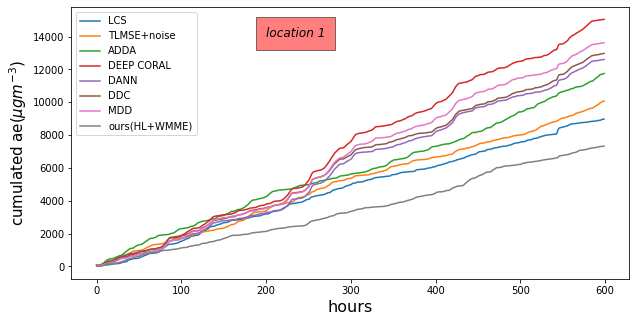

In [ ]:
#2nd loc
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.text(200, 14000, 'location 1', style ='italic',fontsize = 12, bbox={
        'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
ax.plot(lcs_mae,label='LCS')
ax.plot(TLMSE_noisy_mae,label='TLMSE+noise')
ax.plot(ADDA_mae,label='ADDA')
ax.plot(DEEP_cor_mae,label='DEEP CORAL')
ax.plot(DANN_mae,label='DANN')
ax.plot(DDC_mae,label='DDC')
ax.plot(MDD_mae,label='MDD')
ax.plot(our_mae,label='ours(HL+WMME)')
ax.set_ylabel('cumulated ae($\mu$$gm^{-3}$)',fontsize=15)
ax.set_xlabel('hours',fontsize=16)
ax.legend(loc='upper left')

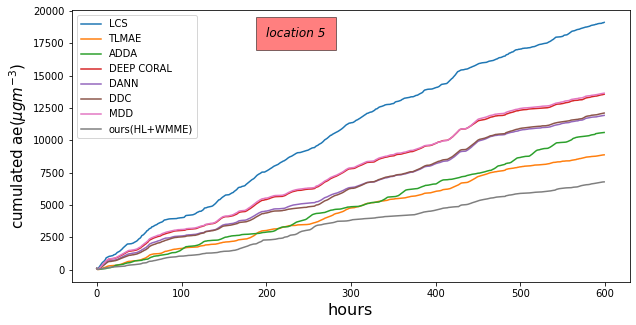

In [ ]:
#6th loc
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.text(200, 18000, 'location 5', style ='italic',fontsize = 12, bbox={
        'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
ax.plot(lcs_mae,label='LCS')
ax.plot(TLMAE_mae,label='TLMAE')
ax.plot(ADDA_mae,label='ADDA')
ax.plot(DEEP_cor_mae,label='DEEP CORAL')
ax.plot(DANN_mae,label='DANN')
ax.plot(DDC_mae,label='DDC')
ax.plot(MDD_mae,label='MDD')
ax.plot(our_mae,label='ours(HL+WMME)')
ax.set_ylabel('cumulated ae($\mu$$gm^{-3}$)',fontsize=15)
ax.set_xlabel('hours',fontsize=16)
ax.legend(loc='upper left')

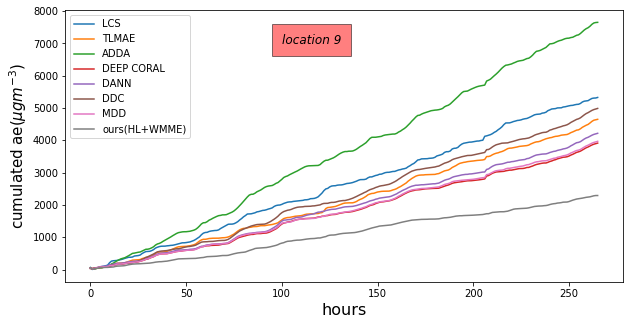

In [ ]:
#12th loc
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.text(100,7000, 'location 9', style ='italic',fontsize = 12, bbox={
        'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
ax.plot(lcs_mae,label='LCS')
ax.plot(TLMAE_mae,label='TLMAE')
ax.plot(ADDA_mae,label='ADDA')
ax.plot(DEEP_cor_mae,label='DEEP CORAL')
ax.plot(DANN_mae,label='DANN')
ax.plot(DDC_mae,label='DDC')
ax.plot(MDD_mae,label='MDD')
ax.plot(our_mae,label='ours(HL+WMME)')
ax.set_ylabel('cumulated ae($\mu$$gm^{-3}$)',fontsize=15)
ax.set_xlabel('hours',fontsize=16)
ax.legend(loc='upper left')

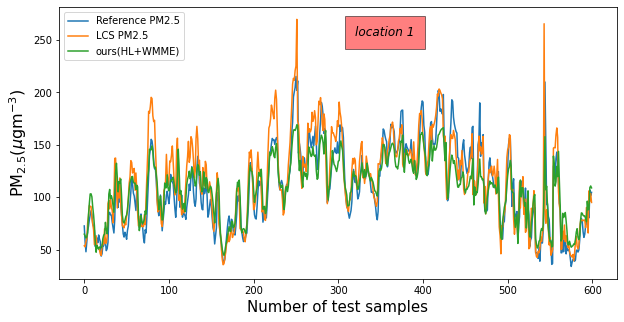

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.text(320,254, 'location 1', style ='italic',fontsize = 12, bbox={
        'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
ax.plot(ref_tar_y_test,label='Reference PM2.5')
ax.plot(lcs_tar_y_test,label='LCS PM2.5')
ax.plot(ours_pred,label='ours(HL+WMME)')
ax.set_xlabel('Number of test samples',fontsize=15)
ax.set_ylabel('PM$_{2.5}$($\mu$gm$^{-3}$)',fontsize=16)
ax.legend(loc='upper left')

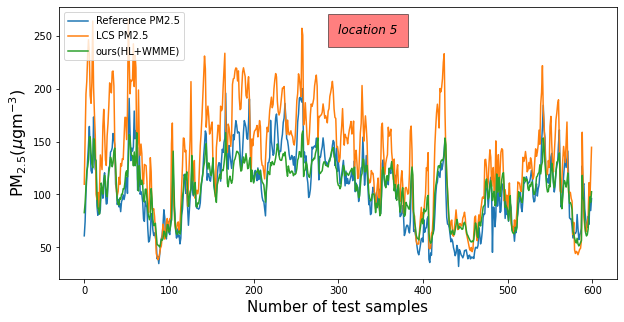

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.text(300,252, 'location 5', style ='italic',fontsize = 12, bbox={
        'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
ax.plot(ref_tar_y_test,label='Reference PM2.5')
ax.plot(lcs_tar_y_test,label='LCS PM2.5')
ax.plot(ours_pred,label='ours(HL+WMME)')
ax.set_xlabel('Number of test samples',fontsize=15)
ax.set_ylabel('PM$_{2.5}$($\mu$gm$^{-3}$)',fontsize=16)
ax.legend(loc='upper left')

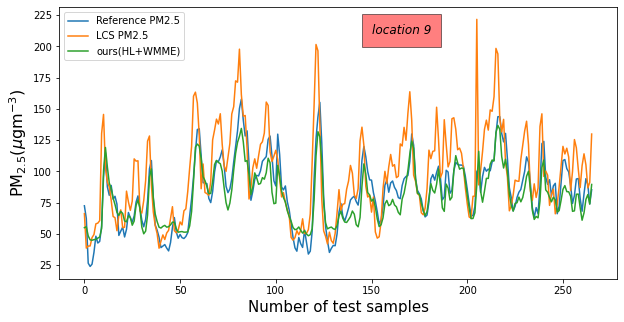

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.text(150,210, 'location 9', style ='italic',fontsize = 12, bbox={
        'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
ax.plot(ref_tar_y_test,label='Reference PM2.5')
ax.plot(lcs_tar_y_test,label='LCS PM2.5')
ax.plot(ours_pred,label='ours(HL+WMME)')
ax.set_xlabel('Number of test samples',fontsize=15)
ax.set_ylabel('PM$_{2.5}$($\mu$gm$^{-3}$)',fontsize=16)
ax.legend(loc='upper left')

In [204]:
tar_name = name_list[13]##########select collocated site as per the name given in the name_list
##########chosing season ### 0=season_1 and 1=season_2
tar_season = seasons[0] 
##########chosing start_ups###0=Respirer, 1=PAQS, 2=Oizom, 3 = Airveda#####
tar_startup = 'Respirer'

Merging the CAAQMs and LCDS values at target location. 

One point one should keep into mind that choose a location as target which differs the source location chosen for training the base model.

In [205]:
tar_df = data_merge_resp(tar_startup)  
##################select season
if tar_season == 'season_1':########season_1
    tar_df = tar_df.loc['2020-11-01 00:00:00':'2021-01-31 23:00:00']
else:###########season_2
    tar_df = tar_df.loc['2021-02-01 00:00:00':'2021-05-31 23:00:00']

             Unnamed: 1
5  Kurla, Mumbai - MPCB
Shape of the Reference data matrix for Kurla is (5425, 4)
Shape of the Respirer data matrix for Kurla is (4266, 4)
shape of the merge dataset at Kurla for Respirer is (4266, 8)


In [206]:
tar_df

,PM25_Ref,PM10_Ref,RH_Ref,AT_Ref,pm25,pm10,temp,rh
Date,,,,,,,,
2020-11-22 15:00:00,117,275.18,55.27,30.54,78.880000,84.760000,31.700000,42.660000
2020-11-22 16:00:00,108.47,277.74,56.23,29.86,87.611111,87.777778,32.000000,43.000000
2020-11-22 18:00:00,119.93,304.56,68.49,26.38,54.388889,63.333333,30.000000,46.277778
2020-11-22 19:00:00,98.65,201,70.02,25.85,36.935484,19.419355,30.983871,47.612903
2020-11-22 20:00:00,80.28,195,69.77,25.05,49.181818,4.272727,31.000000,47.000000
...,...,...,...,...,...,...,...,...
2021-01-31 19:00:00,47.55,197.13,50.73,24.18,65.222222,77.507937,27.777778,36.111111
2021-01-31 20:00:00,51,147,46.67,23.76,68.483871,80.822581,27.000000,32.096774
2021-01-31 21:00:00,53.64,148.56,50.64,22.99,80.476190,93.904762,27.000000,33.698413


In [207]:
########droping the Temp, RH, and PM10 of the CAAQMS from the dataset####
tar_df = tar_df.drop(['AT_Ref', 'PM10_Ref', 'RH_Ref'], axis=1)
tar_df = tar_df.reset_index()

In [208]:
tar_df

,Date,PM25_Ref,pm25,pm10,temp,rh
0,2020-11-22 15:00:00,117,78.880000,84.760000,31.700000,42.660000
1,2020-11-22 16:00:00,108.47,87.611111,87.777778,32.000000,43.000000
2,2020-11-22 18:00:00,119.93,54.388889,63.333333,30.000000,46.277778
3,2020-11-22 19:00:00,98.65,36.935484,19.419355,30.983871,47.612903
4,2020-11-22 20:00:00,80.28,49.181818,4.272727,31.000000,47.000000
...,...,...,...,...,...,...
1467,2021-01-31 19:00:00,47.55,65.222222,77.507937,27.777778,36.111111
1468,2021-01-31 20:00:00,51,68.483871,80.822581,27.000000,32.096774
1469,2021-01-31 21:00:00,53.64,80.476190,93.904762,27.000000,33.698413
1470,2021-01-31 22:00:00,62,102.539683,120.682540,26.682540,39.952381


In [209]:

####################prepare features at target location ################
tar_df = derived_feat(tar_df)

In [210]:

tar_df

,Date,PM25_Ref,pm25,pm10,temp,rh,hour,hour_sin,hour_cos,rh_11,...,(PM10)t-2,(PM10)t-1,p1p2,p1r,p1t,p2r,p2t,p1rt,p2rt,p1p2rt
0,2020-11-22 15:00:00,117,78.880000,84.760000,31.700000,42.660000,16,-8.660254e-01,-0.500000,43.684004,...,NaN,NaN,6685.868800,3365.020800,2500.496000,3615.861600,2686.892000,106671.159360,114622.812720,9.041447e+06
1,2020-11-22 16:00:00,108.47,87.611111,87.777778,32.000000,43.000000,17,-9.659258e-01,-0.258819,44.023810,...,NaN,84.760000,7690.308642,3767.277778,2803.555556,3774.444444,2808.888889,120552.888889,120782.222222,1.058186e+07
2,2020-11-22 18:00:00,119.93,54.388889,63.333333,30.000000,46.277778,19,-9.659258e-01,0.258819,47.299864,...,84.760000,87.777778,3444.629630,2516.996914,1631.666667,2930.925926,1900.000000,75509.907407,87927.777778,4.782294e+06
3,2020-11-22 19:00:00,98.65,36.935484,19.419355,30.983871,47.612903,20,-8.660254e-01,0.500000,48.634357,...,87.777778,63.333333,717.263267,1758.605619,1144.404266,924.611863,601.686785,54488.409587,28648.054647,1.058130e+06
4,2020-11-22 20:00:00,80.28,49.181818,4.272727,31.000000,47.000000,21,-7.071068e-01,0.707107,48.021739,...,63.333333,19.419355,210.140496,2311.545455,1524.636364,200.818182,132.454545,71657.909091,6225.363636,3.061747e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2021-01-31 19:00:00,47.55,65.222222,77.507937,27.777778,36.111111,20,-8.660254e-01,0.500000,37.139592,...,73.645161,77.111111,5055.239859,2355.246914,1811.728395,2798.897707,2152.998236,65423.525377,77747.158534,5.070842e+06
1468,2021-01-31 20:00:00,51,68.483871,80.822581,27.000000,32.096774,21,-7.071068e-01,0.707107,33.128932,...,77.111111,77.507937,5535.043184,2198.111342,1849.064516,2594.144121,2182.209677,59349.006243,70041.891259,4.796740e+06
1469,2021-01-31 21:00:00,53.64,80.476190,93.904762,27.000000,33.698413,22,-5.000000e-01,0.866025,34.728995,...,77.507937,80.822581,7557.097506,2711.919879,2172.857143,3164.441421,2535.428571,73221.836735,85439.918367,6.875879e+06
1470,2021-01-31 22:00:00,62,102.539683,120.682540,26.682540,39.952381,23,-2.588190e-01,0.965926,40.978053,...,80.822581,93.904762,12374.749307,4096.704460,2736.019148,4821.554800,3220.116654,109310.479310,128651.327274,1.319187e+07


Removing the outliers from RH and AT of data features at target location. 

In [211]:

tar_df = temp_rh_outliers(tar_df)

In [212]:


tar_df = tar_df.replace([np.inf, -np.inf],np.nan)
tar_df = tar_df.replace(0,np.nan)
tar_df = tar_df.mask(tar_df.eq('None')).dropna()

In [213]:
tar_df

,Date,PM25_Ref,pm25,pm10,temp,rh,hour,hour_sin,hour_cos,rh_11,...,(PM10)t-2,(PM10)t-1,p1p2,p1r,p1t,p2r,p2t,p1rt,p2rt,p1p2rt
57,2020-11-26 22:00:00,142.72,112.322581,122.629032,28.854839,51.370968,23,-2.588190e-01,0.965926,52.390820,...,108.677966,124.603175,13774.009365,5770.119667,3241.049948,6299.572060,3538.440947,166495.872327,181773.135741,2.041723e+07
58,2020-11-26 23:00:00,137.36,92.428571,0.095238,31.000000,54.222222,24,-2.449294e-16,1.000000,55.241011,...,124.603175,122.629032,8.802721,5011.682540,2865.285714,5.164021,2.952381,155362.158730,160.084656,1.479640e+04
59,2020-11-27 00:00:00,129.68,73.500000,0.435484,31.000000,52.983871,1,2.588190e-01,0.965926,54.003108,...,122.629032,0.095238,32.008065,3894.314516,2278.500000,23.073621,13.500000,120723.750000,715.282258,5.257325e+04
60,2020-11-27 01:00:00,91,63.904762,0.746032,31.000000,51.365079,2,5.000000e-01,0.866025,52.384934,...,0.095238,0.435484,47.674981,3282.473167,1981.047619,38.319980,23.126984,101756.668178,1187.919375,7.591370e+04
61,2020-11-27 02:00:00,78.53,59.806452,0.661290,31.000000,50.000000,3,7.071068e-01,0.707107,51.020408,...,0.435484,0.746032,39.549428,2990.322581,1854.000000,33.064516,20.500000,92700.000000,1025.000000,6.130161e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2021-01-31 19:00:00,47.55,65.222222,77.507937,27.777778,36.111111,20,-8.660254e-01,0.500000,37.139592,...,73.645161,77.111111,5055.239859,2355.246914,1811.728395,2798.897707,2152.998236,65423.525377,77747.158534,5.070842e+06
1468,2021-01-31 20:00:00,51,68.483871,80.822581,27.000000,32.096774,21,-7.071068e-01,0.707107,33.128932,...,77.111111,77.507937,5535.043184,2198.111342,1849.064516,2594.144121,2182.209677,59349.006243,70041.891259,4.796740e+06
1469,2021-01-31 21:00:00,53.64,80.476190,93.904762,27.000000,33.698413,22,-5.000000e-01,0.866025,34.728995,...,77.507937,80.822581,7557.097506,2711.919879,2172.857143,3164.441421,2535.428571,73221.836735,85439.918367,6.875879e+06
1470,2021-01-31 22:00:00,62,102.539683,120.682540,26.682540,39.952381,23,-2.588190e-01,0.965926,40.978053,...,80.822581,93.904762,12374.749307,4096.704460,2736.019148,4821.554800,3220.116654,109310.479310,128651.327274,1.319187e+07


In [214]:
tar_innu1 = tar_df.drop(['Date','PM25_Ref','hour'],axis=1) ## dropping the date and PM2.5_ref column of CAAQMS data.

In [215]:
tar_innu_f1 = tar_innu1.iloc[:,:].values

In [216]:
tar_outu1 = tar_df[['PM25_Ref']] ## making PM2.5_ref feature of CAAQMS as out ground truth at target location

In [217]:
tar_outu_f1 = tar_outu1.iloc[:,:].values

In [218]:
tar_lcs = tar_df[['pm25']]

In [219]:
tar_lcs_f1 = tar_lcs.iloc[:,:].values

In [220]:
# # Preparing training, validation and testing dataset 
ta = 48 # set 1 month 8 days unlabeled data for unsupervised training
tb = 912+48 # set next 2 days labeled data for supervised training
tc = tb+168 # set next 1 week data for validation
td = tc+600 # use to set 25 days data for testing in Testset-1: 
e = tar_df.shape[0] # Remaining data in Testset-2

In [193]:
# # Preparing training, validation and testing dataset 
ta = 48 # set 1 month 8 days unlabeled data for unsupervised training
tb = 600+48 # set next 2 days labeled data for supervised training
tc = tb+168 # set next 1 week data for validation
td = tc+tar_innu_f1.shape[0] # use to set 25 days data for testing in Testset-1: 

In [194]:
# # Preparing training, validation and testing dataset 
ta = 48 # set 1 month 8 days unlabeled data for unsupervised training
tb = 399+48 # set next 2 days labeled data for supervised training
tc = tb+120 # set next 1 week data for validation
td = tc+tar_innu_f1.shape[0]

In [195]:
# # Preparing training, validation and testing dataset 
ta = 48 # set 1 month 8 days unlabeled data for unsupervised training
tb = 528+48 # set next 2 days labeled data for supervised training
tc = tb+111 # set next 1 week data for validation
td = tc+tar_innu_f1.shape[0] # use to set 25 days data for testing in Testset-1: 

In [ ]:
lcs_lab_tar_y_train = tar_lcs_f1[:ta,:].astype(np.float32)
lcs_unlab_tar_y_train = tar_lcs_f1[ta:tb,:].astype(np.float32)
lcs_tar_y_val = tar_lcs_f1[tb:tc,:].astype(np.float32)
lcs_tar_y_test = tar_lcs_f1[tc:td,:].astype(np.float32)

In [ ]:
num_bins = np.arange(20,1220,40)

In [ ]:
best_model = DDsemsupTG_performance_eval(innu1,outu_f1,tar_innu_f1,tar_outu_f1,num_bins,a,b,ta,tb,tc,td)

In [ ]:
#dd
0.49286468096357294,20.908288955688477,19.55280601978302,19.5048344930013(180,1)
0.6409448245026781,16.185739517211914,13.351061940193176,13.981820424397785(580,1)
0.13019653618833205,24.635730743408203,32.964709401130676,26.351496378580727(20,1)
0.7515499802587697,19.738128662109375,20.55097371339798,18.882227541510023(60,0.1)
0.7416793150923786,13.876093864440918,15.037134289741516,13.909371693929035(1100,0.1)
0.5814662605844526,14.277792930603027,14.599153399467468,15.733909606933592(340,1)
0.3572693225691037,9.70751667022705,12.741570174694061,12.379521528879803(60,1)
0.3948094011895189,19.891803741455078,20.459948480129242,21.468475341796875(180,1)
0.7388899038303259,11.266756057739258,15.248806774616241,14.921320291390096(140,1)
0.4573549298363473,22.2965087890625,23.263199627399445,23.119641913742317(60)

In [ ]:
best_model = semsupTG_performance_eval(innu1,outu_f1,tar_innu_f1,tar_outu_f1,num_bins,a,b,ta,tb,tc,td)

In [ ]:
best_model = semsupTG_performance_wweval(innu1,outu_f1,tar_innu_f1,tar_outu_f1,num_bins,a,b,ta,tb,tc,td)

In [ ]:
#unsup without weighting
0.6878373332880492,15.706977844238281,13.364815711975098,13.81771723429362(980,0.1)(0.7879035420599222)
0.6410467455598827,15.78768539428711,11.847250908613205,12.760191599527994(780,0.1)(0.9281445177237858)
0.2591807543858794,22.906843185424805,28.414496779441833,23.851313273111977(980,0.1)(-0.15722986049581822)
0.6080662448523526,24.056072235107422,20.547768473625183,19.056711220801024(60,0.1)(0.5664170267641847)
0.7210213966756237,13.918892860412598,14.558631181716919,13.714574178059895(580,0.1)(0.7446451597921045)
0.4999724275313646,15.532916069030762,14.565344154834747,16.03290957789267(540,0.1)(0.8196556164032356)
0.4816111412456787,8.121838569641113,10.779383778572083,10.830023288726807(220,0.1)(0.37913839643378333)
0.4879034931917329,17.92727279663086,17.612747848033905,18.606435139973957(660,0.1)(0.6473026133624806)
0.7415829932805041,10.480549812316895,12.207099795341492,12.950326446303746(620,0.1)(0.7376046462486013)
0.5566781707708843,19.251333236694336,18.95708441734314,19.57068521468366(980)(0.6045428187654276)

In [ ]:
best_supmodel = supTG_performance_eval(innu1,outu_f1,tar_innu_f1,tar_outu_f1,num_bins,a,b,ta,tb,tc,td)

In [ ]:
ENT_mod = semsupTG_ENT(innu1,outu_f1,tar_innu_f1,tar_outu_f1,num_bins,a,b,ta,tb,tc,td)

In [ ]:
#ENT_mod
0.8178010773096832,12.815260887145996,13.079065084457397,12.381296793619791(1020,1)(0.6451579929676144)
0.5829683840541061,17.253042221069336,12.960013747215271,14.156600952148438(220,0.1)(0.926551138057534)
0.2548337239315026,23.416521072387695,27.219918370246887,24.330744425455727(820,1)(0.03557491195562568)
0.7971545577723037,15.903608322143555,13.172374665737152,13.447656846584234(1180,0.1)(0.5212139691379694)
0.7929084314948681,12.471770286560059,13.952532410621643,12.83551025390625(1,260)(0.8279270450723358)
0.6371231846068854,13.22065544128418,12.376418709754944,13.19898328473491(1060,0.1)(0.8290481260319751)
0.4887844226524981,7.768072605133057,10.141357034444809,10.07498025894165(420,0.1)(0.29753133996198167)
0.6451805947289733,15.30167293548584,15.23858904838562,16.152901967366535(620,0.1)(0.7229852849611332)
0.7804443759684974,9.50015926361084,11.027071624994278,11.52417032342208(1140,1)(0.7663055737708379)
0.5837085366068635,18.33304214477539,18.066421151161194,18.556380141628246(460)(0.6140554777432105)